In [3]:
import sys, time, timeit, cProfile, pstats, importlib, os, math, scipy

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import matplotlib
%matplotlib notebook
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (40., 7.)
matplotlib.rcParams.update({'font.size': 22})

%load_ext autoreload
%autoreload 2

import itertools as it
from numpy.polynomial.legendre import legvander

from Database import *
from Densities import *
from MultiIndex import *
from Surrogates import *
from Forward import *
from Transport import *
import TransportSparse

import plotutil, randutil

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from scipy.special import legendre

polys = [legendre(i)*np.sqrt((2*i + 1)/2) for i in range(multis.maxDegree)]
polys = [(p*p).integ() for p in polys]

def bisection(f,y) :
    midpoint = lambda interval : interval[0] + (interval[1] - interval[0])/2
    interval = [-1,1]
    x = 0
    candidate = f(x)
    for _ in range(30) :
        if candidate > y : interval = [interval[0],  x]
        else :             interval = [x, interval[1]]
        x = midpoint(interval)
        candidate = f(x)
    return x

In [3]:
multis = SparseSet.withSize(weights=[.6, .4], n=10, t=60)
polys = [legendre(i)*np.sqrt((2*i + 1)/2) for i in range(multis.maxDegree)]
n = 100
d = multis.dim
m = multis.cardinality
samples = np.random.uniform(low=-1, high=1, size=(d, n))
weights = np.zeros((n,))
for i in range(n) :
    idx = multis[np.random.randint(low=0, high=m)].asList()
    for j in range(d) :
        samples[i,j] = bisection(polys[idx[j]], samples[i,j])
    weights[i] = 

In [2]:
def create_targets(save=True) :
    n_targets = 1
    ds = [3][::-1]
    alphas = [3,5]
    noises = [.02, .1, .2, .5]
    wkerns = [10]
    xmeas = np.linspace(-.9,.9,10)

    targets = []
    for (d, noise, alpha, wkern) in itertools.product(ds, noises, alphas, wkerns) :
        print(d, noise, alpha, wkern)
        forwd = Convolution(basis=basis.hats_cdec, dim=d, alpha=alpha, wkern=wkern, nquad=1000, xmeas=xmeas, save=save)
        posts = GaussianPosterior.fromConfig(fwd=forwd, noise=noise)
        n_preex_targets = min(len(posts), n_targets)
        targets += posts[:n_preex_targets]
        targets += [GaussianPosterior(forwd=forwd, truep=randutil.points(d), noise=noise, save=save) for _ in range(n_preex_targets, n_targets)]
    return targets

In [3]:
cProfile.run('create_targets()', 'stats_test')

3 0.02 3 10
3 0.02 5 10
3 0.1 3 10
3 0.1 5 10
3 0.2 3 10
3 0.2 5 10
3 0.5 3 10
3 0.5 5 10


In [4]:
pstats.Stats('stats_test').sort_stats(pstats.SortKey.CUMULATIVE).print_stats(40)

Sun Mar 19 20:39:05 2023    stats_test

         267310 function calls (263574 primitive calls) in 1.769 seconds

   Ordered by: cumulative time
   List reduced from 366 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.769    1.769 {built-in method builtins.exec}
        1    0.000    0.000    1.769    1.769 <string>:1(<module>)
        1    0.000    0.000    1.769    1.769 /tmp/ipykernel_24790/2685293947.py:1(create_targets)
        8    0.008    0.001    1.684    0.210 /home/uq/apps/spatram/Forward.py:9(__init__)
      240    0.794    0.003    0.794    0.003 /home/uq/apps/spatram/Forward.py:28(<listcomp>)
        8    0.000    0.000    0.653    0.082 /usr/lib/python3.10/site-packages/numpy/polynomial/legendre.py:1520(leggauss)
  347/337    0.001    0.000    0.418    0.001 {built-in method numpy.core._multiarray_umath.implement_array_function}
        8    0.000    0.000    0.416    0.052 <__array_f

# Transport Map Evaluation

In [52]:
def get_properties(n, mode, multis) :
    t = Gaussian(mean=randutil.points(multis.dim,1), cova=randutil.covarm(multis.dim), save=False)
    s = Legendre(multis=multis, target=t, method=mode, n=n, save=False)
    
    L_svd = np.linalg.svd(s.L, compute_uv=False)
    G_svd = np.linalg.svd(s.G, compute_uv=False)
    
    e = s.computeError()
    
    return min(L_svd), max(L_svd), min(G_svd), max(G_svd), s.L.shape[0], e.hedist, e.nevals

def test(n=500) :
    for multis in [TotalDegreeSet(dim=2,order=3), SparseSet.withSize(weights=[.6, .4], n=10, t=60), SparseSet.withSize(weights=[.6, .4, .3, .1], n=15, t=60)] :
        for mode in ['cheby', 'tp_light', 'shuffled'] :
            print(multis.name, mode)
            for i in range(n):
                get_properties(300, mode, multis)
test(2)

totaldegree cheby
totaldegree tp_light
totaldegree shuffled
sparse cheby
sparse tp_light
sparse shuffled
sparse cheby
sparse tp_light
sparse shuffled


In [61]:
cProfile.run('test()', 'stats_test_4')

totaldegree cheby
totaldegree tp_light
totaldegree shuffled
sparse cheby
sparse tp_light
sparse shuffled
sparse cheby
sparse tp_light
sparse shuffled


In [59]:
pstats.Stats('stats_test_5').sort_stats(pstats.SortKey.CUMULATIVE).print_stats(20)

Mon Mar  6 21:04:38 2023    stats_test_5

         3543525 function calls (3543410 primitive calls) in 23.506 seconds

   Ordered by: cumulative time
   List reduced from 320 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   23.506   23.506 {built-in method builtins.exec}
        1    0.000    0.000   23.506   23.506 <string>:1(<module>)
        1    0.012    0.012   23.506   23.506 /tmp/ipykernel_21017/3793106663.py:12(test)
     4500    0.047    0.000   23.432    0.005 /tmp/ipykernel_21017/3793106663.py:1(get_properties)
     4500    0.013    0.000   17.275    0.004 /home/uq/apps/spatram/Surrogates.py:72(computeError)
     4500    0.479    0.000   17.261    0.004 /home/uq/apps/spatram/Surrogates.py:82(__init__)
    20046    0.263    0.000   13.635    0.001 /home/uq/apps/spatram/Surrogates.py:62(evalSqrt)
    24546    0.993    0.000   13.483    0.001 /home/uq/apps/spatram/legendreutil.py:53(evaluate_bas

In [62]:
pstats.Stats('stats_test_4').sort_stats(pstats.SortKey.CUMULATIVE).print_stats(20)

Mon Mar  6 21:05:59 2023    stats_test_4

         3551625 function calls (3551510 primitive calls) in 21.671 seconds

   Ordered by: cumulative time
   List reduced from 321 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   21.671   21.671 {built-in method builtins.exec}
        1    0.000    0.000   21.671   21.671 <string>:1(<module>)
        1    0.011    0.011   21.671   21.671 /tmp/ipykernel_21017/3793106663.py:12(test)
     4500    0.048    0.000   21.639    0.005 /tmp/ipykernel_21017/3793106663.py:1(get_properties)
     4500    0.013    0.000   15.550    0.003 /home/uq/apps/spatram/Surrogates.py:72(computeError)
     4500    0.465    0.000   15.536    0.003 /home/uq/apps/spatram/Surrogates.py:82(__init__)
    19936    0.236    0.000   12.182    0.001 /home/uq/apps/spatram/Surrogates.py:62(evalSqrt)
    24436    0.896    0.000   12.077    0.000 /home/uq/apps/spatram/legendreutil.py:53(evaluate_bas

In [41]:
pstats.Stats('stats_test_4').sort_stats(pstats.SortKey.CUMULATIVE).print_stats(20)

Mon Mar  6 17:43:07 2023    stats_test_4

         8260977 function calls (8260862 primitive calls) in 16.611 seconds

   Ordered by: cumulative time
   List reduced from 321 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   16.612   16.612 {built-in method builtins.exec}
        1    0.000    0.000   16.612   16.612 <string>:1(<module>)
        1    0.002    0.002   16.611   16.611 /tmp/ipykernel_21017/2069277678.py:12(test)
      900    0.009    0.000   16.585    0.018 /tmp/ipykernel_21017/2069277678.py:1(get_properties)
      900    0.002    0.000   15.472    0.017 /home/uq/apps/spatram/Surrogates.py:72(computeError)
      900    2.421    0.003   15.469    0.017 /home/uq/apps/spatram/Surrogates.py:82(__init__)
   606487    1.471    0.000    7.047    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    73377    0.130    0.000    6.993    0.000 /home/uq/apps/spatram/Surrogat

In [33]:
p = pstats.Stats('stats_test_3')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats(20)

Mon Mar  6 17:32:44 2023    stats_test_2

         1241012 function calls (1240657 primitive calls) in 2.902 seconds

   Ordered by: cumulative time
   List reduced from 344 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.902    2.902 {built-in method builtins.exec}
        1    0.000    0.000    2.902    2.902 <string>:1(<module>)
        1    0.000    0.000    2.902    2.902 /tmp/ipykernel_21017/3718299755.py:12(test)
      120    0.002    0.000    2.837    0.024 /tmp/ipykernel_21017/3718299755.py:1(get_properties)
      120    0.000    0.000    2.184    0.018 /home/uq/apps/spatram/Surrogates.py:72(computeError)
      120    0.332    0.003    2.183    0.018 /home/uq/apps/spatram/Surrogates.py:82(__init__)
    10647    0.025    0.000    1.007    0.000 /home/uq/apps/spatram/Surrogates.py:62(evalSqrt)
    87877    0.207    0.000    0.993    0.000 {built-in method numpy.core._multiarray_umath.implemen

In [24]:
p = pstats.Stats('stats_test')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats(20)

Mon Mar  6 16:02:11 2023    stats_test

         2893422 function calls (2893067 primitive calls) in 4.845 seconds

   Ordered by: cumulative time
   List reduced from 344 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    4.845    4.845 {built-in method builtins.exec}
        1    0.000    0.000    4.845    4.845 <string>:1(<module>)
        1    0.001    0.001    4.845    4.845 /tmp/ipykernel_14275/4070804449.py:38(test)
      120    0.002    0.000    4.819    0.040 /tmp/ipykernel_14275/4070804449.py:1(get_properties)
      120    0.000    0.000    4.083    0.034 /home/uq/apps/spatram/Surrogates.py:72(computeError)
      120    0.374    0.003    4.083    0.034 /home/uq/apps/spatram/Surrogates.py:82(__init__)
    11546    0.029    0.000    2.763    0.000 /home/uq/apps/spatram/Surrogates.py:62(evalSqrt)
    11696    0.049    0.000    2.728    0.000 /home/uq/apps/spatram/legendreutil.py:53(evaluate_basis)

# Inverse Evaluation

In [8]:
d = 3
arglist = [{'mean' : randutil.points(d,1), 'cova' : randutil.covarm(d)},
           {'mean' : randutil.points(d,1), 'cova' : randutil.covarm(d)}]
t = GaussianMixture(dim=d, arglist=arglist, save=False)
m = mi.TotalDegreeSet(dim=d, order=4)
s = Legendre(multis=m, target=t)
tm = TransportMap(s)

def test() :
    for _ in range(100) :
        x = np.random.uniform(low=-1, high=1, size=(d,))
        y = tm.eval(x)
#        require.close(tm.inveval(y), x, atol=1e-3)
        require.close(tm.inveval_smart(y), x, atol=1e-3)

In [9]:
cProfile.run('test()', 'stats_test')

In [10]:
p = pstats.Stats('stats_test')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats(20)

Thu Jul  6 21:12:54 2023    stats_test

         2180804 function calls (2180504 primitive calls) in 2.726 seconds

   Ordered by: cumulative time
   List reduced from 75 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.726    2.726 {built-in method builtins.exec}
        1    0.000    0.000    2.726    2.726 <string>:1(<module>)
        1    0.001    0.001    2.726    2.726 /tmp/ipykernel_14903/2929279535.py:9(test)
      100    0.020    0.000    2.617    0.026 /home/uq/apps/spatram/Transport.py:64(inveval_smart)
     9000    0.603    0.000    2.593    0.000 /home/uq/apps/spatram/Transport.py:47(eval_i)
     9300    0.804    0.000    1.356    0.000 /home/uq/apps/spatram/legendreutil.py:24(get_integrated_products)
    65100    0.259    0.000    0.634    0.000 /usr/lib/python3.11/site-packages/numpy/lib/index_tricks.py:34(ix_)
     9300    0.347    0.000    0.467    0.000 /usr/lib/python3.11/site-pack

In [7]:
p = pstats.Stats('stats_test')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats(20)

Thu Jul  6 21:12:22 2023    stats_test

         6411204 function calls (6410904 primitive calls) in 7.903 seconds

   Ordered by: cumulative time
   List reduced from 72 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.903    7.903 {built-in method builtins.exec}
        1    0.000    0.000    7.903    7.903 <string>:1(<module>)
        1    0.001    0.001    7.903    7.903 /tmp/ipykernel_14903/2924128095.py:9(test)
     9200    1.862    0.000    7.860    0.001 /home/uq/apps/spatram/Transport.py:14(eval)
      100    0.019    0.000    7.795    0.078 /home/uq/apps/spatram/Transport.py:87(inveval)
    27600    2.352    0.000    3.957    0.000 /home/uq/apps/spatram/legendreutil.py:24(get_integrated_products)
   193200    0.748    0.000    1.835    0.000 /usr/lib/python3.11/site-packages/numpy/lib/index_tricks.py:34(ix_)
    27600    1.013    0.000    1.361    0.000 /usr/lib/python3.11/site-packages/num

# Surrogate Construction

In [86]:
t = Rosenbrock(a=.15, b=10)
m = TotalDegreeSet(dim=2, order=9)

points, weights = get_sample_points_and_weights('wls', m)
rhs = np.squeeze(t.evalSqrt(points))
lhs = legendreutil.evaluate_basis(points, m)
print(m.cardinality, points.shape, rhs.shape, lhs.shape)

if weights is not None:
    for i in range(lhs.shape[0]) :
        lhs[i,:] *= weights[i]
        rhs[i] *= weights[i]

def run_nplstsq() :
    coeffs, res, rank, s = np.linalg.lstsq(lhs, rhs, rcond=None)
    #print(res/rhs.shape[0], rank)
    #print(s)
    return coeffs

def run_nppinv() :
    inv = np.linalg.pinv(lhs)
    return np.dot(inv, rhs)

def run_splstsq() :
    coeffs, _, _, _ = scipy.linalg.lstsq(lhs, rhs)
    return coeffs

def run_optimize() :
    def func(x) :
        return np.dot(lhs, x.T) - rhs
    coeffs, _ = scipy.optimize.leastsq(func, np.zeros((lhs.shape[1],)))
    return coeffs

x = run_nplstsq()

55 (2, 2200) (2200,) (2200, 55)
[0.00862235] 55
[23.40830114 23.14720178 22.84668282 22.34100962 21.85139675 21.33151785
 20.96468981 20.50644781 20.053087   19.95806551 19.63828657 19.09709324
 18.85933355 18.59433476 18.10617269 17.9428856  17.31888695 17.07112903
 16.86836911 16.37230611 16.04601958 15.77097308 15.3171758  15.16737062
 14.8383832  14.51947229 14.42277025 14.0367189  13.93246398 13.54502661
 13.43232531 13.30724461 12.98024161 12.05005489 11.91110769 11.70581374
 11.50651549 10.99284557 10.94263373 10.70936685 10.49717672 10.29976824
  9.87153589  9.76370775  9.47880244  9.20349956  8.91769722  8.84735949
  8.70015154  8.14197036  7.94346712  7.27938749  6.70109161  6.46457062
  5.88981337]


In [78]:
c1 = run_nplstsq()
c2 = run_optimize()
print(c1 - c2)

[ 1.73752124e-11  3.17801341e-12 -3.60003694e-13 -9.99828415e-11
 -3.35051570e-11  1.35865486e-11 -4.69166477e-11  7.88503464e-12
 -3.72222808e-11  1.17669263e-10  2.66446379e-11  1.58889450e-10
  2.06712733e-11  2.97639660e-11  1.15699277e-10 -2.82425056e-11
  7.25799759e-11 -6.74612745e-11  4.60941250e-11  3.03548853e-11
  3.39333023e-11  7.59792507e-11 -7.14941162e-11 -3.30795599e-11
  7.92106103e-11  1.43247220e-11 -2.49446991e-11 -5.29600877e-11
  1.69469100e-10  5.91149039e-11 -4.07486176e-12  1.47909579e-10
 -1.29371467e-10  4.53608366e-11  7.36458117e-11  1.24160265e-11
  6.35609620e-11 -3.44923985e-11  3.41061901e-11  1.22174389e-10
  1.48716438e-11  1.44916660e-10  4.50390038e-11 -2.22087227e-11
  1.16249513e-10  2.26422700e-12  3.89271254e-11  9.93212387e-11
 -8.13542705e-11 -4.16625935e-13  5.56199208e-11  6.48072828e-11
  4.54366861e-11  2.20748940e-11  2.58438913e-11]


In [47]:
timeit.repeat(run_nplstsq, repeat=1, number=1)

[73.21716557500076]

In [80]:
timeit.repeat(run_optimize, repeat=1, number=1)

[238.19883692000076]

In [48]:
timeit.repeat(run_splstsq, repeat=1, number=1)

[73.77029162899998,
 78.31270684000083,
 85.31312828299997,
 78.64938330199948,
 84.29982718700012]

In [24]:
cProfile.run('run_nplstsq()', 'stats_run_nplstsq')

In [32]:
cProfile.run('run_nppinv()', 'stats_run_nppinv')

In [33]:
cProfile.run('run_splstsq()', 'stats_run_splstsq')

In [36]:
p = pstats.Stats('stats_run_splstsq')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats()

Fri Apr  1 12:33:20 2022    stats_run_splstsq

         52 function calls in 6.928 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    6.928    6.928 {built-in method builtins.exec}
        1    0.000    0.000    6.928    6.928 <string>:1(<module>)
        1    0.000    0.000    6.928    6.928 /tmp/ipykernel_5801/2816693092.py:22(run_splstsq)
        1    6.914    6.914    6.928    6.928 /usr/lib/python3.10/site-packages/scipy/linalg/_basic.py:1036(lstsq)
        2    0.000    0.000    0.013    0.007 /usr/lib/python3.10/site-packages/scipy/_lib/_util.py:241(_asarray_validated)
        2    0.012    0.006    0.013    0.007 /usr/lib/python3.10/site-packages/numpy/lib/function_base.py:537(asarray_chkfinite)
        3    0.001    0.000    0.001    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.001    0.001 {method 'all' of 'numpy.ndarray' objects}
        2    0.00

# Transport Map Evaluation

In [3]:
t = Rosenbrock(a=.15, b=10)
m = TotalDegreeSet(dim=2, order=9)
s = Legendre(multis=m, target=t, method='wls')
r = TransportMap(s)

def run() :
    p = randutil.points(2,1000)
    i = np.zeros(p.shape)
    for j in range(p.shape[1]) :
        i[:,j] = r.inveval(p[:,j])

In [33]:
cProfile.run('run()', 'stats')

In [2]:
p = pstats.Stats('stats')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats()

Tue Mar 15 10:59:18 2022    stats

         28670007 function calls in 52.949 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   52.949   52.949 {built-in method builtins.exec}
        1    0.000    0.000   52.949   52.949 <string>:1(<module>)
        1    0.003    0.003   52.949   52.949 /tmp/ipykernel_5284/3898437028.py:6(run)
     1000    0.136    0.000   52.945    0.053 /home/uq/spatram_tmp/Transport.py:47(inveval)
    61000    5.387    0.000   52.776    0.001 /home/uq/spatram_tmp/Transport.py:14(eval)
   122000   22.590    0.000   33.887    0.000 /home/uq/spatram_tmp/legendreutil.py:22(get_integrated_products)
  2745000    3.658    0.000   12.718    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   122000    7.742    0.000    9.581    0.000 /usr/lib/python3.10/site-packages/numpy/polynomial/legendre.py:1126(legvander)
   671000    0.364    0.000    8.415    0.

# Evaluating the Legendre basis

In [3]:
def setup(d=2, n=10, k=7) :

    rng = np.random.default_rng()
    x = rng.uniform(low=-1, high=1, size=(d, n))
    van = legvander(x, k)
    indices = [idx for idx in it.product(range(k+1), repeat=d)]
    m = len(indices)
    mat = np.zeros((n, m))
    return x, van, indices, mat

def run1(x, van, indices, mat, d=2, n=10, k=7) :
    for i in range(n) :
        for j in range((k+1)**d) :
            mat[i,j] = np.prod([van[k,i,indices[j][k if k < len(indices[j]) else 0]] for k in range(d)])
            mat[i,j] *= np.prod([np.sqrt((2*i + 1)/2) for i in indices[j]])
    return mat
            
def run2(x, van, indices, mat, d=2, n=10, k=7) :
    for i in range(n) :
        mat[i,:] = [np.prod([van[k,i,idx[di if di < len(idx) else 0]] for di in range(d)])*np.prod([np.sqrt((2*l + 1)/2) for l in idx]) for idx in it.product(range(k+1), repeat=d)]
    return mat
            
def run3(x, van, indices, mat, d=2, n=10, k=7) :
    map1 = lambda l : np.sqrt((2*l + 1)/2)
    map2 = lambda q : van[q[0],i,q[1]]
    for i in range(n) :
        mat[i,:] = [math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in it.product(range(k+1), repeat=d)]
    return mat
        
def run4(x, van, indices, mat, d=2, n=10, k=7) :
    map1 = lambda l : np.sqrt((2*l + 1)/2)
    map2 = lambda q : van[q[0],:,q[1]]
    return np.array([math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in indices]).T


def run5(x, van, indices, mat, d=2, n=10, k=7) :
    def map1(l) : return np.sqrt((2*l + 1)/2)
    def map2(q) : return van[q[0],:,q[1]]
    return np.array([math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in indices]).T

def run6(x, van, indices, mat, d=2, n=10, k=7) :
    def map1(l) : return np.sqrt((2*l + 1)/2)
    def map2(q) : return van[q[0],:,q[1]]
    return np.array([math.prod(map(map2, enumerate(idx)))*math.prod(map(map1, idx)) for idx in indices]).T
    
d = 2
k = 2
n = 3
x, van, indices, mat = setup(d=d, n=n, k=k)
print(run1(x, van, indices, np.zeros((n, (k+1)**d)), d=d, n=n, k=k).T)
print(run5(x, van, indices, np.zeros((n, (k+1)**d)), d=d, n=n, k=k).T)

[[ 0.5         0.5         0.5       ]
 [-0.0818832   0.52708955  0.61128947]
 [-0.54402447  0.062215    0.27654529]
 [-0.56133557 -0.68074749  0.84297877]
 [ 0.09192791 -0.71762978  1.03060808]
 [ 0.61076058 -0.0847054   0.46624361]
 [ 0.14556271  0.47721526  1.02996243]
 [-0.02383828  0.50307035  1.25921037]
 [-0.15837935  0.05937989  0.56966251]]
[[ 0.5         0.5         0.5       ]
 [-0.0818832   0.52708955  0.61128947]
 [-0.54402447  0.062215    0.27654529]
 [-0.56133557 -0.68074749  0.84297877]
 [ 0.09192791 -0.71762978  1.03060808]
 [ 0.61076058 -0.0847054   0.46624361]
 [ 0.14556271  0.47721526  1.02996243]
 [-0.02383828  0.50307035  1.25921037]
 [-0.15837935  0.05937989  0.56966251]]


In [26]:
dslong = [2,3,4,5,6,7,8]
ds = [2,3,4,5]

In [6]:
times1 = [timeit.repeat(setup = 'from __main__ import setup, run1; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run1(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

In [8]:
times3 = [timeit.repeat(setup = 'from __main__ import setup, run3; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run3(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

In [9]:
times4 = [timeit.repeat(setup = 'from __main__ import setup, run4; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run4(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

In [30]:
times6 = [timeit.repeat(setup = 'from __main__ import setup, run6; x, van, indices, mat = setup(d={})'.format(d), stmt = 'run6(x, van, indices, mat, d={})'.format(d), repeat=2, number = 1) for d in ds]

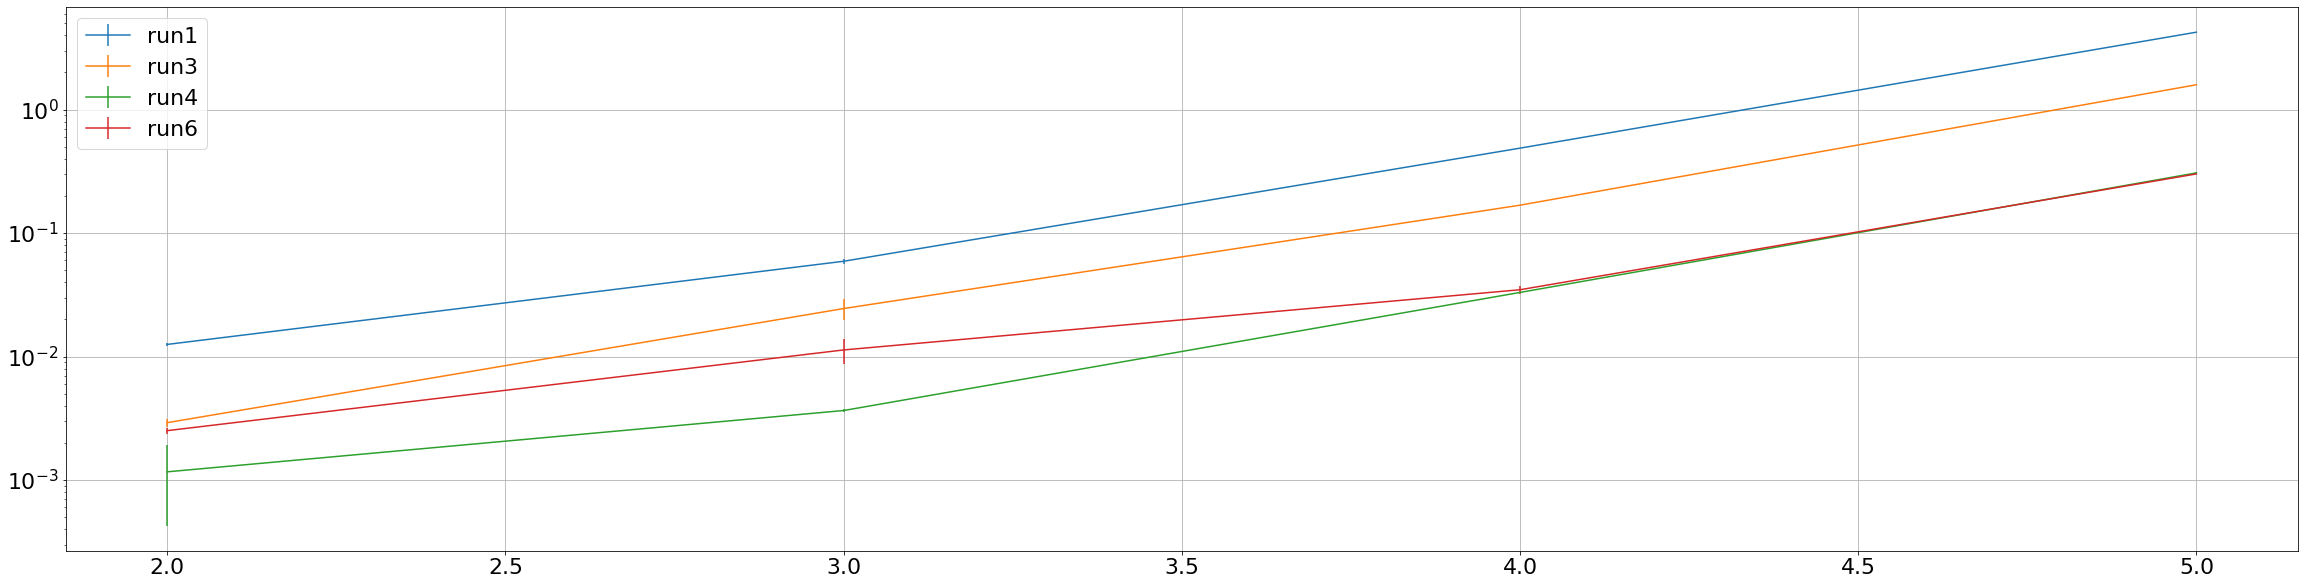

In [31]:
fig = plt.figure(figsize=(40,10))
ax = plotutil.get_ax(fig, 1, 1, xlabel='', logaxis=['y'])
ax.errorbar(ds, np.mean(times1, axis=1), np.std(times1, axis=1), label='run1')
ax.errorbar(ds, np.mean(times3, axis=1), np.std(times3, axis=1), label='run3')
ax.errorbar(ds, np.mean(times4, axis=1), np.std(times4, axis=1), label='run4')
ax.errorbar(ds, np.mean(times6, axis=1), np.std(times6, axis=1), label='run6')
ax.legend()
plt.show()

In [141]:
ds = [3,7,15,31,63]
ns = [10,50,100,200,300,500]
res = np.zeros((len(ds), len(ns), 3))
for i,d in enumerate(ds) :
    forwd  = Convolution(basis=basis.hats_cdec, dim=d, alpha=3, wkern=10, xmeas=np.linspace(-.9,.9,10))
    for j,n in enumerate(ns) :
        print(d, n)
        multis = SparseSet.withSize(weights=forwd.dimWeights(), n=n, t=1)
        points, x = pointutil.get_sample_points_and_weights(multis, 'cheby', None, 'wls')
        res[i,j,0] = multis.size()
        res[i,j,1] = np.mean(timeit.repeat(setup = 'from __main__ import points, multis; import legendreutil', stmt = 'legendreutil.evaluate_basis(points, multis, mode=\'old\')', repeat=5, number = 1))
        res[i,j,2] = np.mean(timeit.repeat(setup = 'from __main__ import points, multis; import legendreutil', stmt = 'legendreutil.evaluate_basis(points, multis)', repeat=5, number = 1))
        

3 10
3 50
3 100
3 200
3 300
3 500
7 10
7 50
7 100
7 200
7 300
7 500
15 10
15 50
15 100
15 200
15 300
15 500
31 10
31 50
31 100
31 200
31 300
31 500
63 10
63 50
63 100
63 200
63 300
63 500


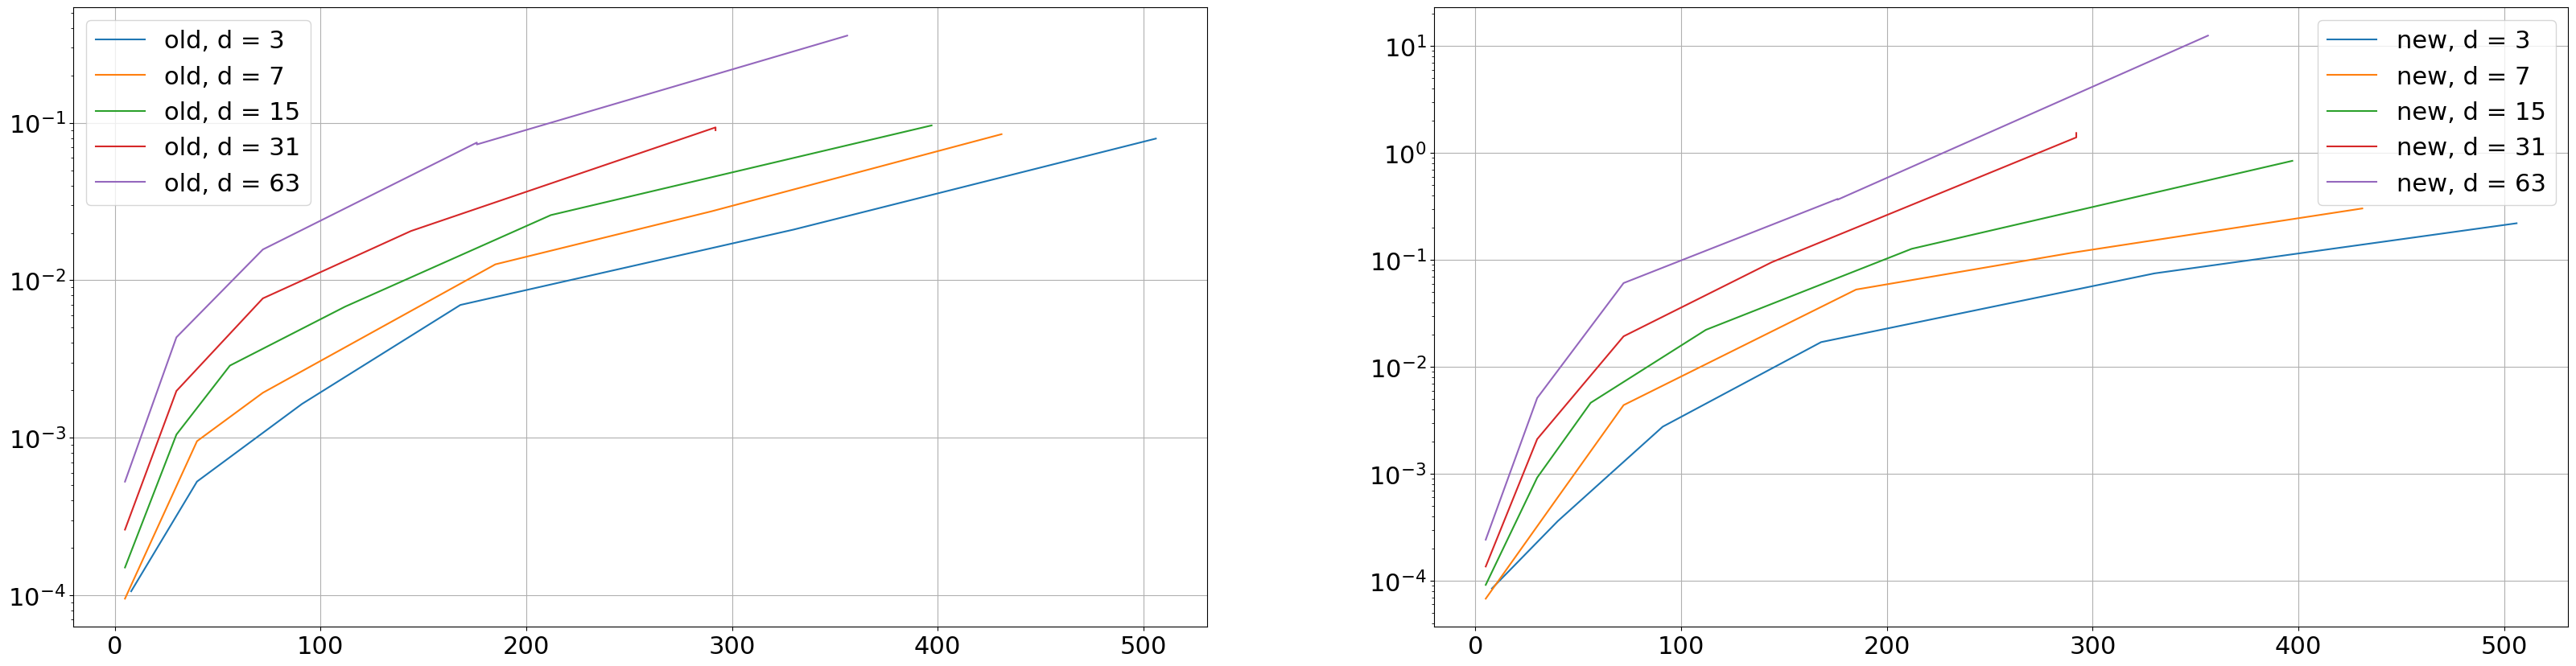

In [149]:
fig=plt.figure(figsize=(40,10))
ax = plotutil.get_ax(fig=fig, nx=2, idx=1, xlabel='', logaxis=['y'])
for i,d in enumerate(ds) :
    ax.plot(res[i,:,0], res[i,:,1], label='old, d = '+str(d))
plt.legend()
ax = plotutil.get_ax(fig=fig, nx=2, idx=2, xlabel='', logaxis=['y'])
for i,d in enumerate(ds) :
    ax.plot(res[i,:,0], res[i,:,2], label='new, d = '+str(d))
plt.legend()
plt.show()

In [137]:
n = 800
multis = SparseSet.withSize(weights=forwd.dimWeights(), n=n, t=1)
print(multis.size())
points, x = pointutil.get_sample_points_and_weights(multis, 'cheby', None, 'wls')

749


In [122]:
I = np.random.randint(low=0, high=8, size=(63, 356))
V = np.empty(shape=(63, 356, 17800))
R = np.prod([V[i,:,I[:,i]] for i in range(I.shape[0])], axis=0).T

In [124]:
timeit.repeat(setup = 'from __main__ import I, V; import numpy as np', stmt = 'R = np.prod([V[i,:,I[:,i]] for i in range(I.shape[0])], axis=0).T', repeat=5, number = 1)

[0.25782193000486586,
 0.2563833709937171,
 0.21920395699999062,
 0.19797170600213576,
 0.21827853599825175]

In [ ]:
timeit.repeat(setup = 'from __main__ import I, V; import numpy as np', stmt = 'R = np.prod([V[i,:,I[:,i]] for i in range(I.shape[0])], axis=0).T', repeat=5, number = 1)

In [130]:
I = np.array(multis.asLists()).T # shape = (d, m)
V = legvander(points, multis.maxDegree) # shape = (d, n, multis.maxDegree+1)
R = np.prod([V[i,:,I[:,i]] for i in range(I.shape[0])], axis=0).T

In [85]:
V.shape, I.shape

((63, 17800, 8), (63, 356))

In [90]:
np.array([V[i,:,I[i,:]] for i in range(I.shape[0])]).shape

(63, 356, 17800)

In [131]:
idx = I[:,:,np.newaxis]

# Use advanced indexing to select the values from V corresponding to the indices in idx
R = V[np.arange(V.shape[0])[:,np.newaxis,np.newaxis], :, idx]

# Remove the singleton dimension to get the desired shape of (63, 17800, 356)
R = np.squeeze(R, axis=2)
R = np.prod(R, axis=0).T

In [126]:
# Reshape the V array to a 2D array with shape (63*17800, 8)
V_flat = V.reshape((-1, V.shape[-1]))

# Reshape the I array to a 1D index array with shape (63*356, )
I_flat = I.ravel()

# Use the take method to select the values from V_flat corresponding to the indices in I_flat
R_flat = np.take(V_flat, I_flat, axis=0)

# Compute the number of elements in the resulting array
num_elements = I.shape[-1] * V.shape[1]

# Reshape the resulting array to the desired shape of (356, 17800)
R = R_flat[:num_elements].reshape((I.shape[-1], V.shape[1])).T

ValueError: cannot reshape array of size 179424 into shape (356,17800)

In [87]:
R = np.prod([V[i,:,I[:,i]] for i in range(multis.dim)], axis=0).T

In [40]:
cProfile.run('legendreutil.evaluate_basis(points, multis, mode=\'old\')', 'stats_old')

In [54]:
cProfile.run('legendreutil.evaluate_basis(points, multis)', 'stats_new2')

In [41]:
p = pstats.Stats('stats_old')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats()

Wed May 10 18:19:31 2023    stats_old

         45962 function calls in 0.328 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.328    0.328 {built-in method builtins.exec}
        1    0.000    0.000    0.328    0.328 <string>:1(<module>)
        1    0.000    0.000    0.328    0.328 /home/uq/apps/spatram/legendreutil.py:53(evaluate_basis)
        1    0.003    0.003    0.269    0.269 /home/uq/apps/spatram/legendreutil.py:69(<listcomp>)
      712    0.238    0.000    0.266    0.000 {built-in method math.prod}
        1    0.051    0.051    0.051    0.051 /usr/lib/python3.11/site-packages/numpy/polynomial/legendre.py:1126(legvander)
    22428    0.018    0.000    0.018    0.000 /home/uq/apps/spatram/legendreutil.py:66(<lambda>)
    22428    0.010    0.000    0.010    0.000 /home/uq/apps/spatram/legendreutil.py:67(<lambda>)
        2    0.008    0.004    0.008    0.004 {built-in method numpy.

In [42]:
p = pstats.Stats('stats_new')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats()

Wed May 10 18:19:07 2023    stats_new

         26746 function calls in 2.776 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.777    2.777 {built-in method builtins.exec}
        1    0.003    0.003    2.776    2.776 <string>:1(<module>)
        1    0.029    0.029    2.774    2.774 /home/uq/apps/spatram/legendreutil.py:53(evaluate_basis)
      357    0.000    0.000    2.319    0.006 <__array_function__ internals>:177(prod)
      358    0.000    0.000    2.318    0.006 {built-in method numpy.core._multiarray_umath.implement_array_function}
      357    0.000    0.000    2.318    0.006 /usr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:2955(prod)
      357    0.001    0.000    2.318    0.006 /usr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:69(_wrapreduction)
      357    2.316    0.006    2.316    0.006 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.333    0.3

In [55]:
p = pstats.Stats('stats_new2')
p.sort_stats(pstats.SortKey.CUMULATIVE).print_stats()

Wed May 10 18:52:54 2023    stats_new2

         401 function calls in 1.612 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    1.612    1.612 {built-in method builtins.exec}
        1    0.001    0.001    1.612    1.612 <string>:1(<module>)
        1    0.025    0.025    1.611    1.611 /home/uq/apps/spatram/legendreutil.py:53(evaluate_basis)
        2    0.000    0.000    1.028    0.514 {built-in method numpy.core._multiarray_umath.implement_array_function}
        1    0.000    0.000    1.027    1.027 <__array_function__ internals>:177(prod)
        1    0.000    0.000    1.027    1.027 /usr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:2955(prod)
        1    0.000    0.000    1.027    1.027 /usr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:69(_wrapreduction)
        1    1.027    1.027    1.027    1.027 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.330    0.33